In [1]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc
import scFates as scf

In [2]:
adata = sc.read('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_others/c1_anndata.h5ad')#sc.read('latentvelo_C1.h5ad')
adata.obs['annotations'] = adata.obsm['Clusters'][:,0]
adata.obs.annotations = adata.obs.annotations.astype('category')

adata.var['HB'] = adata.var_names.isin(['HBB','HBA1','HBA2','HBG2','HBG1','HBD', 'HBM', 'HBZ'])
adata = adata[:,~(adata.var['HB'])]

del adata.layers['spliced']
del adata.layers['unspliced']
del adata.layers['ambiguous']
del adata.layers['matrix']
gc.collect()

adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')

meta = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c1_metadata.csv', index_col=0)#sc.read('latentvelo_C1.h5ad')

adata.obs['cell_type'] = meta['cell_type']

GW = np.array([float(x.split('_')[1][:2]) for x in meta['sample_name']])
D = np.array([0 if len(x.split('_')) == 2 else float(x.split('_')[2]) for x in meta['sample_name']])
meta['GW'] = [str(int(GW[i])) + '.' + str(int(D[i])) for i in range(len(GW))]#/7.0)
meta['GD'] = [GW[i]+D[i]/7.0 for i in range(len(GW))]#/7.0)
adata.obs['GW'] = meta['GW']
adata.obs['GD'] = meta['GD']

adata = adata[~adata.obs.annotations.isin(['Chondrocyte','Airway SMC', 'Vascular SMC'])]
gc.collect()
sc.pp.filter_genes(adata, min_cells=300)
gc.collect()
sc.pp.normalize_total(adata)
gc.collect()
sc.pp.log1p(adata)
gc.collect()

0

In [3]:
adata.write('../../../../../../media/spencer/Extra HDD/lung_data/preprocessed_stromal_subset.h5ad')

In [2]:
adata = sc.read('../../../../../../media/spencer/Extra HDD/lung_data/preprocessed_stromal_subset.h5ad')

In [3]:
stromal_pal = {'Airway SMC':'#1f77b4', 'Airway fibroblast progenitors':'#ff7f0e', 'Chondrocyte':'#2ca02c', 'Cycling fibroblasts':'#d62728', 'Early fibroblasts':'#9467bd', 'Lipofibroblast precursors':'#8c564b', 'Lipofibroblasts':'#e377c2', 'Uncommitted cells':'#7f7f7f', 'Unknown stromal cells':'#bcbd22', 'Vascular SMC':'#17becf'} 

In [4]:
sc.pp.pca(adata)

In [5]:
mask = (adata.obsm['X_umap'][:,1] > -7) & (adata.obsm['X_umap'][:,1] < 7.8)                                                                      

In [6]:
umap = np.load('new_umap.npy')

In [7]:
adata.shape, umap.shape, adata[mask].shape

((89138, 15234), (89022, 2), (89022, 15234))

In [8]:
adata = adata[mask]

In [9]:
adata.obsm['X_umap'] = umap

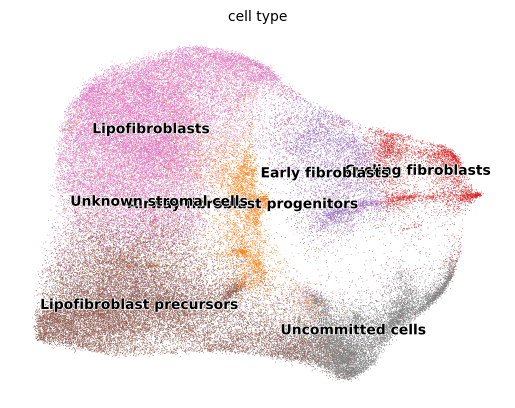

In [10]:
scv.pl.umap(adata, color='cell_type', palette = stromal_pal)

In [11]:
import gc
gc.collect()

3223

In [29]:
np.random.seed(1)
selected = adata[np.random.choice(adata.shape[0], size=40000, replace=False)]
selected = selected[~selected.obs.cell_type.isin(['Uncommitted cells'])]#

In [16]:
np.save('selected_index.npy', selected.obs.index.values)

In [13]:
selected_index=np.load('selected_index.npy', allow_pickle=True)

In [31]:
selected = adata[adata.obs.index.isin(selected_index)]

In [32]:
selected.shape, selected_index.shape, adata.shape, adata[adata.obs.index.isin(selected_index)].shape, mask.sum()

((34612, 15234), (34612,), (89022, 15234), (34612, 15234), 89022)

In [33]:
gc.collect()

737

In [21]:
import rpy2.rinterface_lib.callbacks
import logging
import rpy2.robjects as ro

from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.robjects.conversion import localconverter

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [22]:
%%R
library(anndata)
library(slingshot)
library(Matrix)
library(tradeSeq)


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

In [34]:
sc.pp.highly_variable_genes(selected, n_top_genes = 3000, flavor='cell_ranger', batch_key='batch')#, subset=True)
scv.pp.pca(selected)
gc.collect()

298

In [35]:
gc.collect()

0

In [36]:
dimred = selected.obsm['X_pca'][:,:30]
clustering = selected.obs['cell_type']
batch = selected.obs['batch']

In [37]:
gc.collect()

0

In [27]:
%%R -i dimred -i clustering -i batch 

set.seed(1)

sds <- slingshot(data = dimred, clusterLabels = clustering, start.clus='Cycling fibroblasts',
                 approx_points = 300, thresh = 0.01, stretch = 0.8, allow.breaks = TRUE, shrink = 0.99)

sds <- as.SlingshotDataSet(sds)

pseudotime <- slingPseudotime(sds)#, na = FALSE)
cellWeights <- slingCurveWeights(sds)
write.csv(pseudotime, 'data/Stromal_pseudotimes_nosmc_Cycling.csv')

In [38]:
import pandas as pd
pst = pd.read_csv('data/Stromal_pseudotimes_nosmc_Cycling.csv', index_col=0)
pst

Lineage1   Lineage2   Lineage3
Cell-1      17.688055  17.709875  17.660630
Cell-2      21.439024  17.143073  17.035403
Cell-3            NaN  18.460279        NaN
Cell-4      21.572550        NaN        NaN
Cell-5      16.213347        NaN        NaN
...               ...        ...        ...
Cell-34608        NaN        NaN  24.863828
Cell-34609  25.355830        NaN        NaN
Cell-34610        NaN  23.255153        NaN
Cell-34611  21.698956        NaN        NaN
Cell-34612  20.339227        NaN        NaN

[34612 rows x 3 columns]

In [22]:
pst['index'] = selected_index

In [24]:
pst = pst.set_index('index')

In [39]:
pst

Lineage1   Lineage2   Lineage3
Cell-1      17.688055  17.709875  17.660630
Cell-2      21.439024  17.143073  17.035403
Cell-3            NaN  18.460279        NaN
Cell-4      21.572550        NaN        NaN
Cell-5      16.213347        NaN        NaN
...               ...        ...        ...
Cell-34608        NaN        NaN  24.863828
Cell-34609  25.355830        NaN        NaN
Cell-34610        NaN  23.255153        NaN
Cell-34611  21.698956        NaN        NaN
Cell-34612  20.339227        NaN        NaN

[34612 rows x 3 columns]

In [42]:
selected.obs['pseudotime1'] = pst.Lineage2.values
selected.obs['pseudotime2'] = pst.Lineage3.values
selected.obs['pseudotime3'] = pst.Lineage1.values


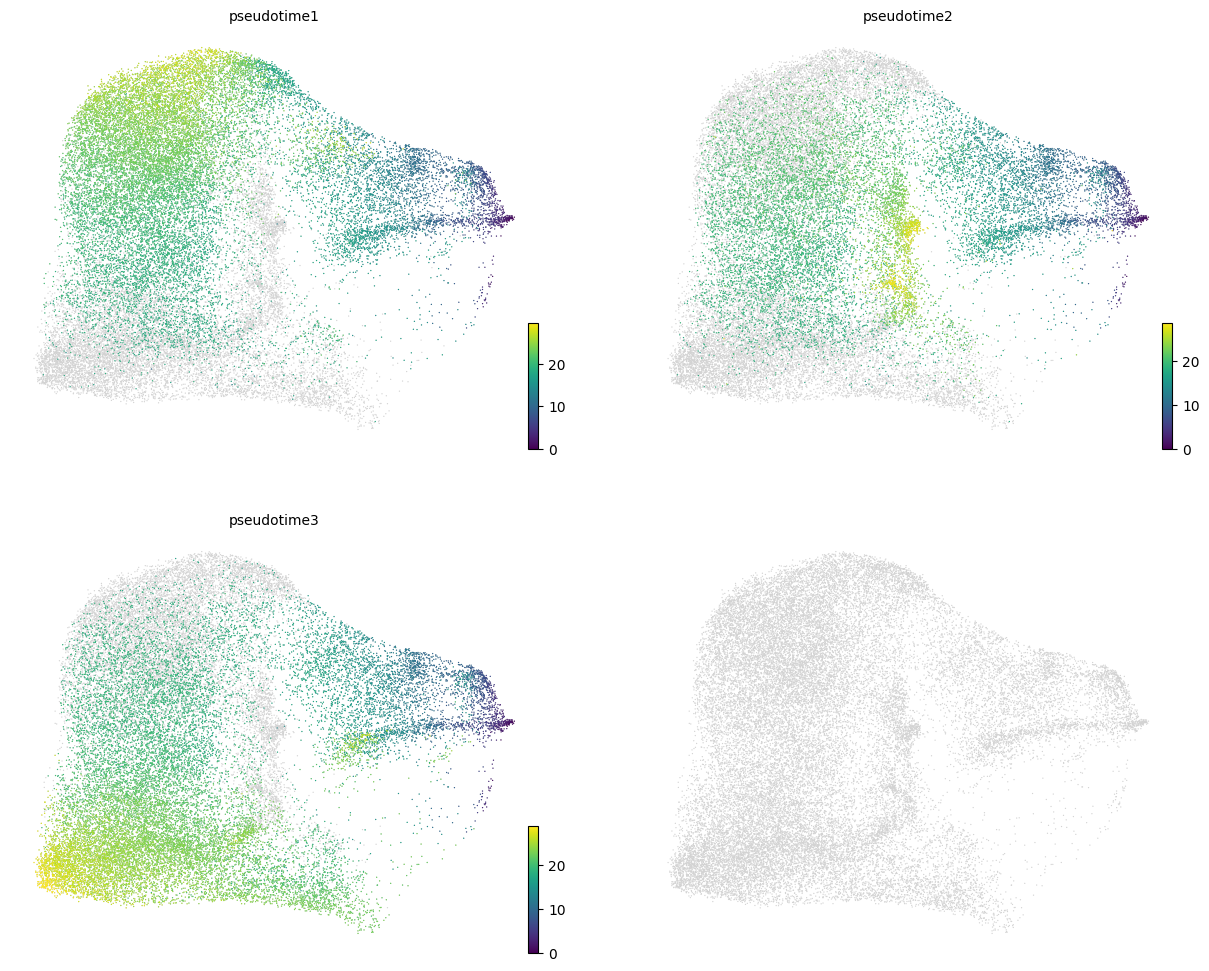

In [43]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,2, figsize=(15,12))
ax=ax.flatten()

scv.pl.umap(selected, color='#D3D3D3', ax=ax[0], show=False)
scv.pl.umap(selected, color='#D3D3D3', ax=ax[1], show=False)
scv.pl.umap(selected, color='#D3D3D3', ax=ax[2], show=False)
scv.pl.umap(selected, color='#D3D3D3', ax=ax[3], show=False)
#scv.pl.umap(selected, color='#D3D3D3', ax=ax[4], show=False)
#scv.pl.umap(selected, color='#D3D3D3', ax=ax[5], show=False)

scv.pl.umap(selected, color='pseudotime1', ax=ax[0], show=False)
scv.pl.umap(selected, color='pseudotime2', ax=ax[1], show=False)
scv.pl.umap(selected, color='pseudotime3', ax=ax[2], 
           show=True)

In [47]:
selected.obs['UMAP1'] = selected.obsm['X_umap'][:,0]
selected.obs['UMAP2'] = selected.obsm['X_umap'][:,1]
selected.obs[['pseudotime1', 'pseudotime2', 'pseudotime3', 'cell_type', 'UMAP1', 'UMAP2']].to_csv('data/stromal_slingshot.csv')

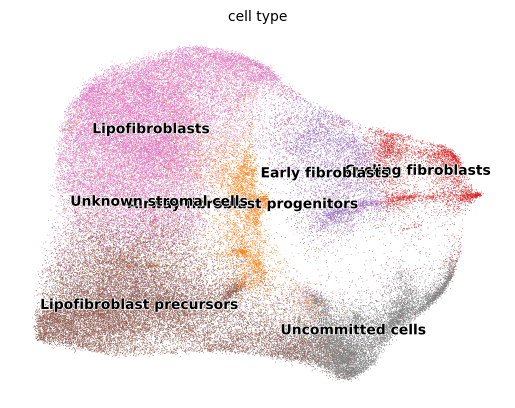

In [48]:
scv.pl.umap(adata, color='cell_type')

saving figure to file figures/Lipofibroblast_trajectory.pdf


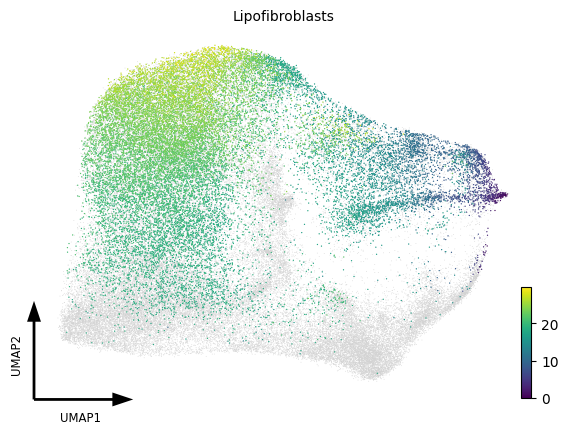

saving figure to file figures/Airway_fibroblast_progenitors_trajectory.pdf


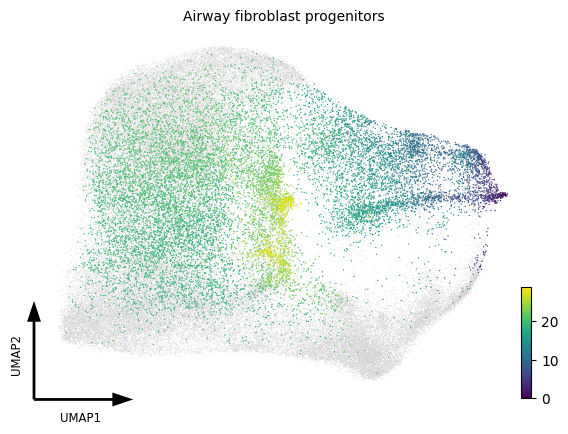

In [49]:
fig,ax=plt.subplots()
scv.pl.umap(adata, color='#D3D3D3',ax=ax, show=False)
scv.pl.umap(selected, color='pseudotime1',ax=ax, show=True, title='Lipofibroblasts',
           save='figures/Lipofibroblast_trajectory.pdf', frameon='artist')


fig,ax=plt.subplots()
scv.pl.umap(adata, color='#D3D3D3',ax=ax, show=False)
scv.pl.umap(selected, color='pseudotime2',ax=ax, show=True, title='Airway fibroblast progenitors',
           save='figures/Airway_fibroblast_progenitors_trajectory.pdf', frameon='artist')

saving figure to file figures/Airway_fibroblast_progenitor_trajectory_new_umap.pdf


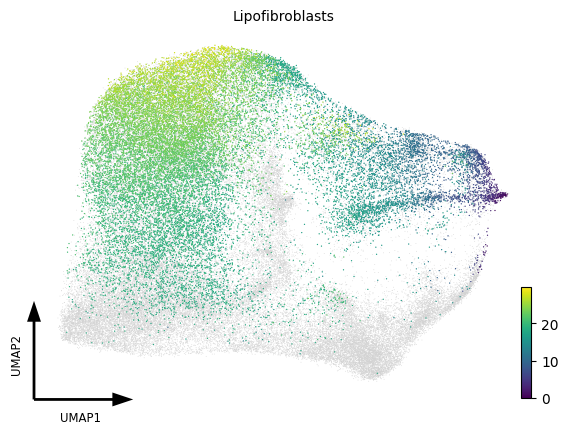

saving figure to file figures/Lipofibroblast_trajectory_new_umap.pdf


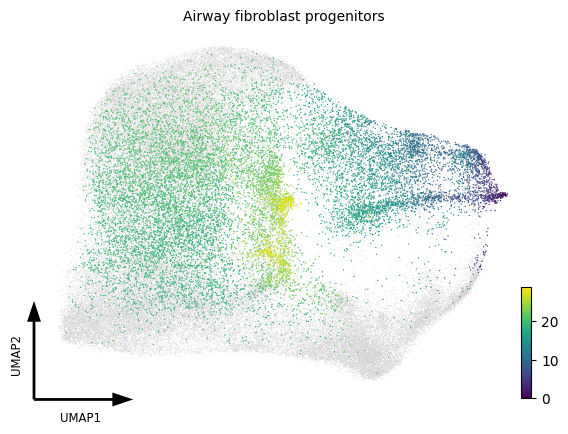

In [50]:
fig,ax=plt.subplots()
scv.pl.umap(adata, color='#D3D3D3',ax=ax, show=False)
scv.pl.umap(selected, color='pseudotime1',ax=ax, show=True, title='Lipofibroblasts',
           save='figures/Airway_fibroblast_progenitor_trajectory_new_umap.pdf', frameon='artist')

#fig,ax=plt.subplots()
#scv.pl.umap(selected, color='#D3D3D3',ax=ax, show=False)
#scv.pl.umap(selected, color='pseudotime2',ax=ax, show=True, title='Airway fibroblast progenitors',
#           save='figures/Airway_fibroblast_progenitor_trajectory.pdf', frameon='artist')

fig,ax=plt.subplots()
scv.pl.umap(adata, color='#D3D3D3',ax=ax, show=False)
scv.pl.umap(selected, color='pseudotime2',ax=ax, show=True, title='Airway fibroblast progenitors',
           save='figures/Lipofibroblast_trajectory_new_umap.pdf', frameon='artist')

In [51]:
degs = pd.read_excel('../Wong_Fetal_Lung_Dataset_August_2023_xlsx', 
                     sheet_name='Stromal')

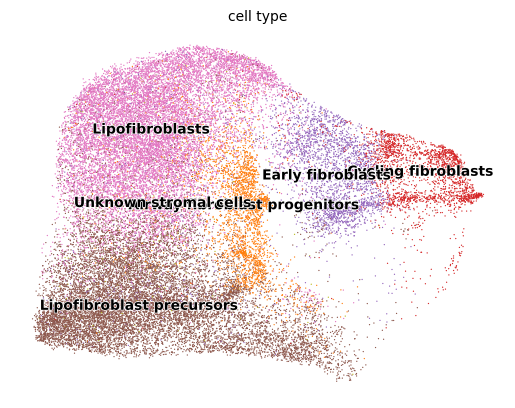

In [52]:
scv.pl.umap(selected, color='cell_type', palette=stromal_pal)

In [54]:
subset = np.random.choice(selected.shape[0], size=10000, replace=False)

In [55]:
selected1 = selected[subset][~selected[subset].obs.pseudotime1.isnull()]
selected1.obs['t'] = selected1.obs['pseudotime1']
selected1.obs['seg'] = 1

In [56]:
selected1 = selected1[:,selected1.var.highly_variable]

In [57]:
selected1

View of AnnData object with n_obs × n_vars = 6257 × 3000
    obs: 'Clusters', '_X', '_Y', 'batch', 'annotations', 'cell_type', 'GW', 'GD', 'pseudotime1', 'pseudotime2', 'pseudotime3', 'UMAP1', 'UMAP2', 't', 'seg'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'HB', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'pca', 'cell_type_colors', 'hvg'
    obsm: 'Clusters', 'X_umap', 'X_pca'
    varm: 'PCs'

In [58]:
gc.collect()

29201

In [59]:
scf.tl.test_association(selected1, n_jobs=4)

test features for association with the trajectory
    single mapping : 100%|██████████| 3000/3000 [03:08<00:00, 15.91it/s]
    found 114 significant features (0:03:08) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [60]:
scf.tl.test_association(selected1,reapply_filters=True,fdr_cut=0.01)

reapplied filters, 114 significant features


In [61]:
selected1.X.shape

(6257, 3000)

In [62]:
selected1.layers['spliced'] = selected1.X.copy()
selected1.layers['unspliced'] = selected1.X.copy()
gc.collect()
scv.pp.neighbors(selected1, n_pcs=30, n_neighbors=30)
gc.collect()
scv.pp.moments(selected1, n_pcs=None, n_neighbors=None)

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [63]:
selected1[:,selected1.var.fdr < 0.01].var_names.shape

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(942,)

In [34]:
np.save('stromal/data/Lipofibro_cycling_genes.csv', selected1[:,selected1.var.fdr < 0.01].var_names)

In [67]:
pd.DataFrame(selected1[~selected1.obs.pseudotime1.isnull()][np.argsort(selected1[~selected1.obs.pseudotime1.isnull()].obs['pseudotime1']),list(selected1[:,selected1.var.fdr < 0.01].var_names)].layers['Ms'],
             index=selected1.obs['pseudotime1'],
            columns=list(selected1[:,selected1.var.fdr < 0.01].var_names)).to_csv('data/Stromal_lipofibroblast_trajectory_heatmap.csv')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


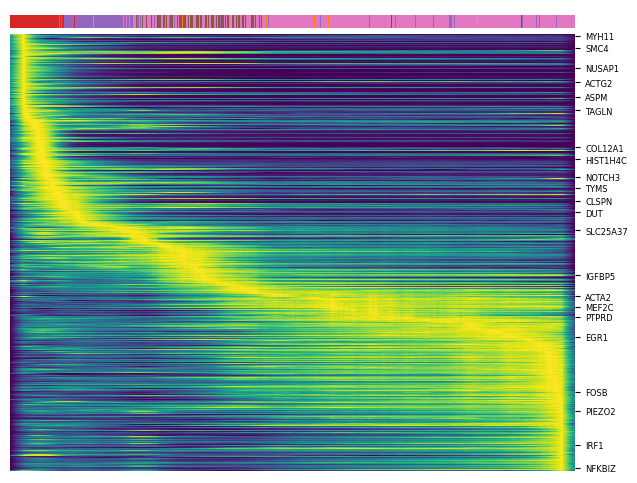

In [65]:
gc.collect()

g= scv.pl.heatmap(selected1[~selected1.obs.pseudotime1.isnull()], sortby='pseudotime1', var_names=list(selected1[:,selected1.var.fdr < 0.01].var_names), #list(selected_ciliated_genes), #pnec_markers,
              n_convolve=300, col_color='cell_type', yticklabels=True, show=False, sort=True, layer='Ms',
                 figsize=(7,5), rasterized=True)


yticklabels = []
yticks = []
for x in g.ax_heatmap.get_yticklabels():
    if x.get_text() in (degs.values[:10].flatten()):
        #print((np.abs(np.array(yticks) - x.get_position()[1])))
        if len(yticks) ==0 or (np.abs(np.array(yticks) - x.get_position()[1])).min() > 20:
            yticklabels.append(x.get_text())
            yticks.append(x.get_position()[1])


g.ax_heatmap.set(yticks=yticks, yticklabels=yticklabels)
g.ax_heatmap.tick_params(labelsize=6)
plt.savefig('figures/Lipofibroblast_cycling_trajectory_heatmap.pdf')
plt.show()

In [68]:
gc.collect()

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


82064

In [69]:
selected1 = selected[subset][~selected[subset].obs.pseudotime2.isnull()]
selected1.obs['t'] = selected1.obs['pseudotime2']
selected1.obs['seg'] = 1

In [70]:
selected1 = selected1[:,selected1.var.highly_variable]

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
gc.collect()
scf.tl.test_association(selected1, n_jobs=4)

test features for association with the trajectory
    single mapping : 100%|██████████| 3000/3000 [02:22<00:00, 21.03it/s]
    found 114 significant features (0:02:22) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [72]:
scf.tl.test_association(selected1,reapply_filters=True,fdr_cut=0.01)

reapplied filters, 114 significant features


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
selected1[:,selected1.var.fdr < 0.01].var_names.shape

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1003,)

In [75]:
selected1.layers['spliced'] = selected1.X.copy()
selected1.layers['unspliced'] = selected1.X.copy()
gc.collect()
scv.pp.neighbors(selected1, n_pcs=30, n_neighbors=30)
gc.collect()
scv.pp.moments(selected1, n_pcs=None, n_neighbors=None)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [45]:
np.save('stromal/data/Airwayfibro_cycling_genes.csv', selected1[:,selected1.var.fdr < 0.01].var_names)

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
pd.DataFrame(selected1[~selected1.obs.pseudotime2.isnull()][np.argsort(selected1[~selected1.obs.pseudotime2.isnull()].obs['pseudotime2']),list(selected1[:,selected1.var.fdr < 0.01].var_names)].layers['Ms'],
             index=selected1.obs['pseudotime2'],
            columns=list(selected1[:,selected1.var.fdr < 0.01].var_names)).to_csv('data/Stromal_airway_fibroblast_trajectory_heatmap.csv')

/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/lib/python3/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


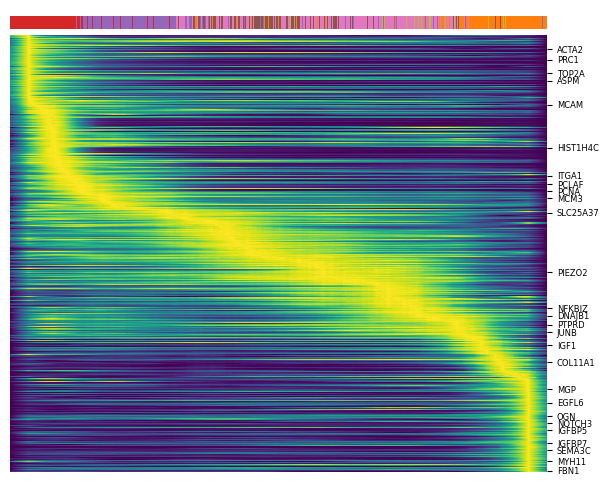

In [76]:
gc.collect()

g= scv.pl.heatmap(selected1[~selected1.obs.pseudotime2.isnull()], sortby='pseudotime2', var_names=list(selected1[:,selected1.var.fdr < 0.01].var_names), #list(selected_ciliated_genes), #pnec_markers,
              n_convolve=300, col_color='cell_type', yticklabels=True, show=False, sort=True,
                 figsize=(7,5), rasterized=True)


yticklabels = []
yticks = []
for x in g.ax_heatmap.get_yticklabels():
    if x.get_text() in (degs.values[:10].flatten()):
        #print((np.abs(np.array(yticks) - x.get_position()[1])))
        if len(yticks) ==0 or (np.abs(np.array(yticks) - x.get_position()[1])).min() > 15:
            yticklabels.append(x.get_text())
            yticks.append(x.get_position()[1])


g.ax_heatmap.set(yticks=yticks, yticklabels=yticklabels)
g.ax_heatmap.tick_params(labelsize=6)
plt.savefig('figures/Airway_fibroblast_progenitors_cycling_trajectory_heatmap.pdf')
plt.show()